# Setup

In [8]:
import os
import sys
import random

import numpy as np
import matplotlib.pyplot as plt

In [1]:
import sys
sys.path.append('..')  

import matftorch 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.utils as vutils

RANDOM_STATE = 1389
random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.use_deterministic_algorithms(True)

In [22]:
CUDA = False
DATA_PATH = './data'
WORKERS = 2
BATCH_SIZE = 1024
IMAGE_CHANNEL = 1
Z_DIM = 100
G_HIDDEN = 64
X_DIM = 64
D_HIDDEN = 64
EPOCH_NUM = 20
REAL_LABEL = 1
FAKE_LABEL = 0
lr = 2e-4

In [23]:
device = matftorch.get_device()
device

device(type='cuda')

# Dataset

U ovom radu koristicemo MNIST skup podataka rukom pisanih cifara 0 - 9.

In [24]:
dataset = dset.MNIST(root=DATA_PATH, download=True,
                     transform=transforms.Compose([
                        transforms.Resize(X_DIM),
                        transforms.ToTensor(),
                        transforms.Normalize((0.5,), (0.5,))
                     ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS)

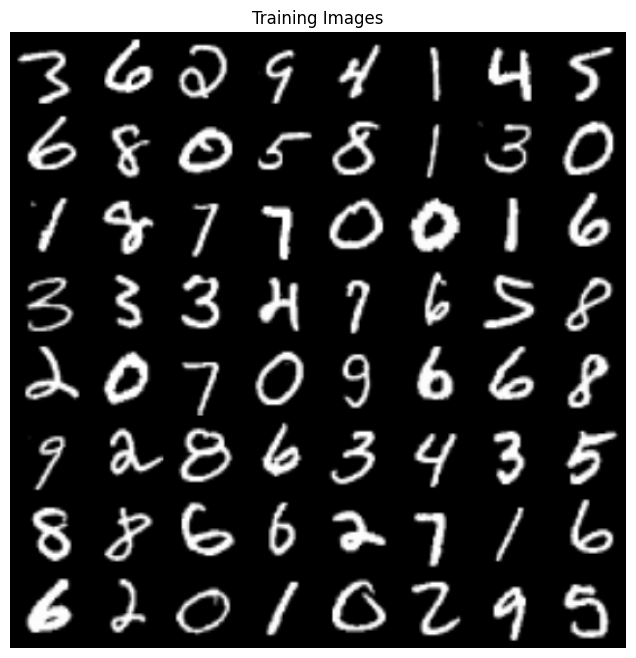

In [25]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

# GAN

Svaka generativna suparnička mreža (engl. Generative Adversarial Network, GAN) se sastoji od generatora i diskriminatora. Generator je neuronska mreža koja na osnovu nasumičnog ulaza treba da generiše što realnije izlaze, dok je diskriminator mreža koja treba da nauči da razlikuje izlaze generatora (lažne izlaze) od pravih podataka. Kako ćemo mi raditi na zadatku generisanja slika, generator bi trebalo da nauči da generiše što je moguće realnije slike cifara, a diskriminator bi trebao da nauči da klasifikuje slike na one koje su prave i one koje su lažne. <img src='assets/GAN_structure.png'>

# DCGAN implementacija

Ova sveska ima za cilj približavanje koncepata generativnih suparničkih mreža i jednog njihovog podtipa koji se (dugačko) naziva **duboke konvolutivne generativne suparničke mreže** (engl. Deep Convolutional Generative Adversarial Network, DCGAN). DCGAN ćemo primeniti u zadatku generisanje slika cifara nalik onima koje se nalaze u MNIST skupu podataka.  

Na slici je prikazana originalna arhitektura DCGAN generatora. Zbog računske zahtevnosti mi ćemo blago modifikovati ovu arhitekturu i prilagoditi je mogućnostima. Predlog je probati i sa pokretanjem ove implementacije u okviru [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb) radnog okruženja koje stavlja na raspolaganje i korišćenje grafičkih kartica.

## Background

Generatorske mreže dobijaju na ulazu nasumičan vektor koji je obično potrebno transformisati u vektor većih dimenzija sa mnogo detalja. Zato se koriste operacije koje su po svom efektu suprotne od operacije agregacije koja se koristi u konvolutivnim neuronskim mrežama.

Jedan način da se postigne ovo uvećanje dimenzije je korišćenje takozvane `upsampling` operacije koja ponavlja vrste i kolone matrice određeni broj puta.
Na primer, za matricu
$\begin{pmatrix}
1 & 2 \\
3 & 4
\end{pmatrix}$
i faktor ponavljanja po vrstama i kolonama zapisan kompaktno (2, 2) odgovarajuća matrica je
$\begin{pmatrix}
1 & 1 & 2 & 2\\
1 & 1 & 2 & 2\\
3 & 3 & 4 & 4\\
3 & 3 & 4 & 4
\end{pmatrix}$.

 Alternativni način povećanja dimenzije je uz korišćenje `transponovane konvolucije`.
<img src='assets/transposed_convolution.png'> Na primer, za ulaz dimenzije 2x2, kernel dimenzije 2x2 i pomeraj (1, 1) dobija se matrica dimenzija 3x3 na način koji je opisan na slici. Za razliku od prethodne tehnike koja ponavlja vrednosti vrsta i kolona, ova tehnika može i da nauči kako da se popune polja nove veće matrice.

U implementaciji DCGANa će biti korišćen i `BatchNormalization` sloj. Funkcija ovog sloja biće vršenje normalizacije vrednosti na način na koji smo to radili i korišćenjem standardnog skaliranja u pripremi podataka, a sa idejom da stabilizujemo i ubrzamo učenje. <img src='assets/batch_normalization.png'>

## Treniranje diskriminatora:

Podaci nad kojima diskriminator uči dolaze iz dva izvora: sa jedne strane to su pravi podaci, a sa druge podaci koje generiše generator. Prave podatke diskriminator uzima kao pozitivne instance, a izlaze generatora kao negativne instance. Prilikom treniranja dikriminator prati svoju funkciju gubitka i ažurira parametre svoje mreže tako da je minimizuje. Dok se diskriminator trenira, generator se **ne trenira** već samo generiše slike koje su potrebne za obučavanje diskriminatora.

In [26]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # 1st layer
            nn.Conv2d(IMAGE_CHANNEL, D_HIDDEN, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # 2nd layer
            nn.Conv2d(D_HIDDEN, D_HIDDEN * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 2),
            nn.LeakyReLU(0.2, inplace=True),

            # 3rd layer
            nn.Conv2d(D_HIDDEN * 2, D_HIDDEN * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # 4th layer
            nn.Conv2d(D_HIDDEN * 4, D_HIDDEN * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 8),
            nn.LeakyReLU(0.2, inplace=True),

            # output layer
            nn.Conv2d(D_HIDDEN * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

## Treniranje generatora:

Generator uči na osnovu povratne informacije koju dobija od diskriminatora. Prilikom treniranja, prvo se za nasumičan ulaz koji prati neku raspodelu generiše odgovarajući izlaz generatora. Zatim se konsultuje diskriminator i prati njegov izlaz. Ovoga puta, uspešnost klasifikacije se ocenjuje koristeći funkciju gubitka generatora na osnovu koje se računaju gradijenti i propagiraju unazad kroz diskriminator i generator i ažuriraju parametri **samo** na nivou generatora.

In [27]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input layer
            nn.ConvTranspose2d(Z_DIM, G_HIDDEN * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 8),
            nn.ReLU(True),

            # 1st hidden layer
            nn.ConvTranspose2d(G_HIDDEN * 8, G_HIDDEN * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 4),
            nn.ReLU(True),

            # 2nd hidden layer
            nn.ConvTranspose2d(G_HIDDEN * 4, G_HIDDEN * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 2),
            nn.ReLU(True),

            # 3rd hidden layer
            nn.ConvTranspose2d(G_HIDDEN * 2, G_HIDDEN, 4, 2, 1, bias=False),
            nn.BatchNorm2d(G_HIDDEN),
            nn.ReLU(True),

            # output layer
            nn.ConvTranspose2d(G_HIDDEN, IMAGE_CHANNEL, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

## Weight Initialization

U DCGAN radu autori definisu da svi težinski parametri modela treba da budu nasumično inicijalizovani iz normalne distribucije sa mean=0 i std_dev=0.2.

Funkcija `weights_init` uzima inicijalizovan model kao ulaz i ponovo inicijalizuje sve slojeve konvolucije, transponovane konvolucije i slojeve za normalizaciju.

In [28]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

## Trening GAN mreže

GAN mreža se trenira tako što se smenjuju treniranja diskriminatora i generatora. Prvo se jednu jednu epohu (ili više epoha) trenira diskriminator, zatim se jednu epohu (ili više epoha) trenira generator, a zatim se ovi koraci smenjuju.

In [29]:
netG = Generator().to(device)
netG.apply(weights_init)
print(netG)
matftorch.count_parameters(netG)

netD = Discriminator().to(device)
netD.apply(weights_init)
print(netD)
matftorch.count_parameters(netD)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


2763520

In [30]:
criterion = nn.BCELoss()

# Create batch of latent vectors that I will use to visualize the progression of the generator
viz_noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1, device=device)

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))

## Trening Loop

In [31]:
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
verbose_delta = 50

print("Training Loop...")
for epoch in range(EPOCH_NUM):
    for i, data in enumerate(dataloader, 0):

        # (1) Update the discriminator with real data
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), REAL_LABEL, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        # (2) Update the discriminator with fake data
        # Generate batch of latent vectors
        noise = torch.randn(b_size, Z_DIM, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(FAKE_LABEL)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        # (3) Update the generator with fake data
        netG.zero_grad()
        label.fill_(REAL_LABEL)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % verbose_delta == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f' % (epoch, EPOCH_NUM, i, len(dataloader), errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == EPOCH_NUM-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(viz_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Training Loop...
[0/20][0/59]	Loss_D: 1.4138	Loss_G: 4.3616	D(x): 0.5811	D(G(z)): 0.4845 / 0.0224
[0/20][50/59]	Loss_D: 0.2333	Loss_G: 11.8580	D(x): 0.9723	D(G(z)): 0.1608 / 0.0000
[1/20][0/59]	Loss_D: 0.0972	Loss_G: 9.3725	D(x): 0.9814	D(G(z)): 0.0670 / 0.0001
[1/20][50/59]	Loss_D: 0.1378	Loss_G: 4.9056	D(x): 0.9545	D(G(z)): 0.0792 / 0.0101
[2/20][0/59]	Loss_D: 0.1164	Loss_G: 5.0168	D(x): 0.9568	D(G(z)): 0.0633 / 0.0088
[2/20][50/59]	Loss_D: 0.2397	Loss_G: 4.1962	D(x): 0.8469	D(G(z)): 0.0417 / 0.0207
[3/20][0/59]	Loss_D: 0.2166	Loss_G: 3.9329	D(x): 0.8870	D(G(z)): 0.0726 / 0.0265
[3/20][50/59]	Loss_D: 0.1261	Loss_G: 4.1399	D(x): 0.9444	D(G(z)): 0.0557 / 0.0237
[4/20][0/59]	Loss_D: 0.1494	Loss_G: 3.5240	D(x): 0.9359	D(G(z)): 0.0724 / 0.0450
[4/20][50/59]	Loss_D: 0.1987	Loss_G: 4.1627	D(x): 0.9198	D(G(z)): 0.0968 / 0.0223
[5/20][0/59]	Loss_D: 0.2319	Loss_G: 3.4546	D(x): 0.8964	D(G(z)): 0.1018 / 0.0429
[5/20][50/59]	Loss_D: 0.2193	Loss_G: 3.3276	D(x): 0.9212	D(G(z)): 0.1162 / 0.0533
[6/2

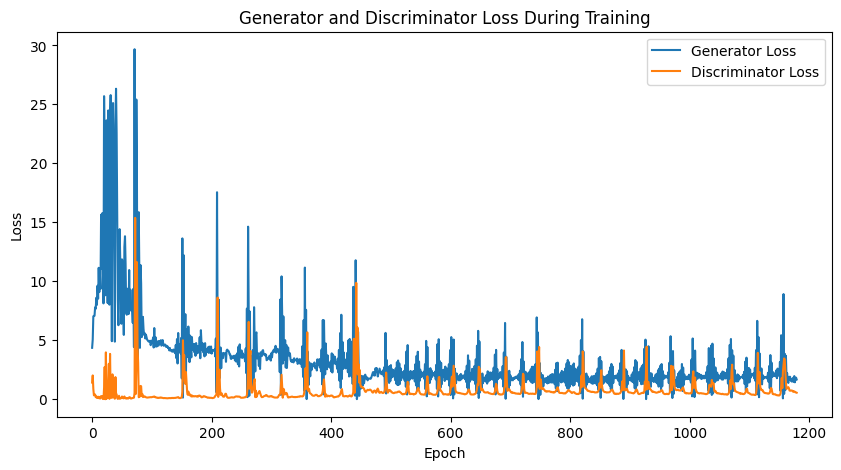

In [32]:
import matplotlib.pyplot as plt

def plot_losses(G_losses, D_losses):
    plt.figure(figsize=(10, 5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses, label="Generator Loss")
    plt.plot(D_losses, label="Discriminator Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

plot_losses(G_losses, D_losses)

## Poredjenje originalnih i generisanih slika

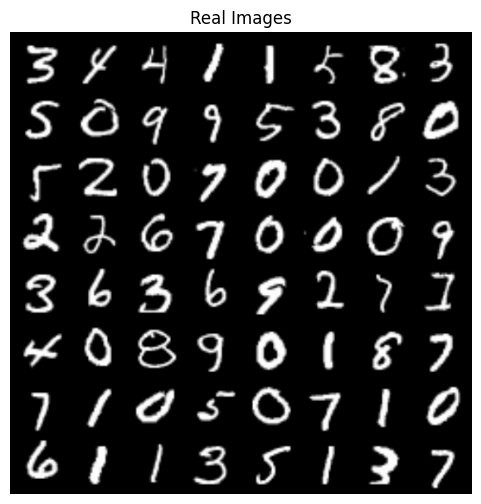

In [33]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(6, 6))
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

In [34]:
img_list[0].shape, img_list[1].shape

(torch.Size([3, 8450, 530]), torch.Size([3, 8450, 530]))

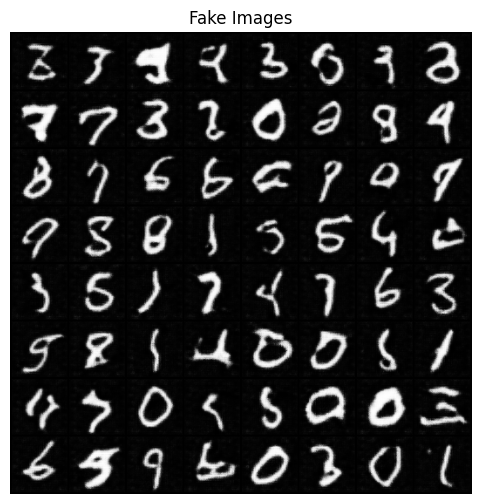

In [35]:
# Plot the fake images from the last epoch
plt.figure(figsize=(6, 6))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1][:,:530,:],(1,2,0)))
plt.show()